<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/DL_2025_Lab7-b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Opcjonalna instalacja gymnasium

!uv pip install gymnasium
!uv pip install "gymnasium[toy-text]"

downloading uv 0.7.11 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
Using Python 3.11.12 environment at: /usr
Audited 1 package in 141ms
Using Python 3.11.12 environment at: /usr
Audited 1 package in 133ms


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def enable_video(env, interval=200):
    """
    Monkey-patch `env` so that:
      - env.frames will accumulate all rgb_array frames whenever you call env.render()
      - env.get_video() returns an IPython.display.HTML object of the animation.
    """
    if env.render_mode != 'rgb_array':
        env.get_video = lambda : "Render mode should be 'rgb_array' to get a video"
        return env  # No recording

    env.frames = []
    orig_render = env.render

    def _render_and_capture(*args, **kwargs):
        frame = orig_render(*args, **kwargs)  # get the RGB array
        env.frames.append(frame)
        return frame

    env.render = _render_and_capture

    def get_video():
        if not env.frames:
            return "No frames in env.frames; make sure you called env.render() at least once."
        fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
        ax.axis("off")
        img = ax.imshow(env.frames[0], interpolation='none', animated=True)

        def _update(i):
            img.set_array(env.frames[i])
            return (img,)

        ani = FuncAnimation(fig, _update,
                            frames=len(env.frames), interval=interval,
                            blit=True, repeat=False)
        plt.close(fig)
        return HTML(ani.to_html5_video())

    env.get_video = get_video
    return env

In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False,
               render_mode='rgb_array')

enable_video(env)

state, info = env.reset()
terminated = False
truncated = False
while not (terminated or truncated):
    action = env.action_space.sample()  # Losowa akcja
    # Przejście do kolejnego stanu
    state, reward, terminated, truncated, info = env.step(action)

    if env.render_mode:
        env.render()   # Dodaje kolejną klatkę animacji

env.close()

env.get_video()

# Q-learning

q.shape = (16, 4)


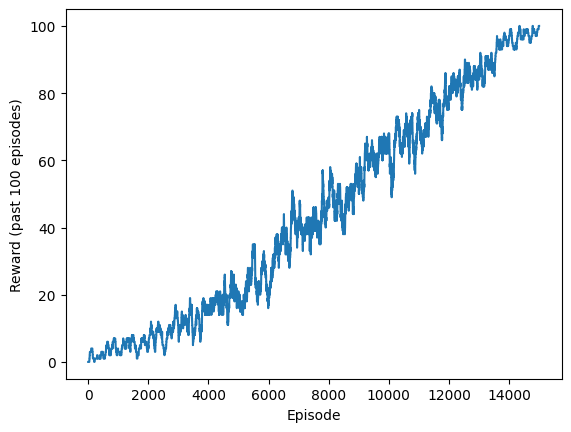

In [ ]:
import numpy as np

def train(episodes):
    env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False,
                render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n))
    print(f'{q.shape = }')

    learning_rate = 0.9
    discount_factor = 0.9

    epsilon = 1
    epsilon_decay_rate = 1 / episodes
    rng = np.random.default_rng()
    rewards = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while not (terminated or truncated):
            if rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state, :])

            new_state, reward, terminated, truncated, _ = env.step(action)

            # Aktualizacja funkcji (tablicy) stanu-akcji
            q[state, action] = q[state, action] + learning_rate * (
                reward + discount_factor * np.max(q[new_state, :]) - q[state, action]
            )
            rewards[i] += reward

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)
        learning_rate = max(learning_rate - 1 / episodes, 1e-4)

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards[max(0, t-100) : t+1])

    plt.plot(sum_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward (past 100 episodes)')
    plt.show()
    return q

q_table = train(15_000)

In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False,
               render_mode='rgb_array')

enable_video(env, interval=300)

state, info = env.reset()
terminated = False
truncated = False
while not (terminated or truncated):
    action = np.argmax(q_table[state, :])
    state, reward, terminated, truncated, info = env.step(action)
    env.render()

env.close()

env.get_video()

# Zad. 1.

Sprawdź działanie algorytmu Q-learning dla problemu FrozenLake-v1 i mapy "8x8".
* Rozważ wariant `is_slippery = False` oraz `is_slippery = True`
* Uruchom algorytm kilka razy, czy zawsze otrzymujemy zbieżność?

# Deep Q-learning

W poniższym przykładzie funkcja stanu--wartości Q przybliżana jest za pomocą sieci neuronowej.
W celu stabilizacji procesu nauki stosowana jest druga sieć, tzw. "docelowa", która
jest aktualizowana rzadziej niż sieć podstawowa, tj. "online".

## Cart Pole

Rozwiązywanym problemem jest [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

enable_video(env, interval=100)

state, info = env.reset()
terminated = False
truncated = False
episode_reward = 0
while not (terminated or truncated):
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    # cart_pos, cart_v, pole_angle, pole_angular_v = state
    episode_reward += 1
    env.render()

env.close()

print(f'{episode_reward = }')
env.get_video()

### Rozwiązanie

In [ ]:
import torch
import torch.nn.functional as F
from collections import deque
from copy import deepcopy

# Hiperparametry
n_inputs = 4
n_outputs = 2
episodes = 200                # liczba epizodów treningu
epsilon_start = 1.0           # początkowe ε dla polityki ε‐greedy
epsilon_end = 0.01            # końcowe ε
epsilon_decay = 200           # liczba epizodów, w ciągu których ε maleje
gamma = 0.99                  # współczynnik dyskontujący
batch_size = 32
lr = 1e-3
target_update_freq = 100      # co ile kroków zaktualizować sieć docelową

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng()

# 1) Definicja sieci online i docelowej
model = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, 32),
    torch.nn.Tanh(),
    torch.nn.Linear(32, n_outputs)
).to(device)

target_model = deepcopy(model).to(device)  # sieć docelowa
target_model.eval()                        # tryb ewaluacji w sieci docelowej

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
replay_buffer = deque(maxlen=2000)

env = gym.make("CartPole-v1", render_mode=None)

# Liniowe wygaszanie ε z epsilon_start do epsilon_end w ciągu epsilon_decay epizodów
def get_epsilon(ep):
    fraction = max(0, (epsilon_decay - ep) / epsilon_decay)
    return epsilon_end + (epsilon_start - epsilon_end) * fraction

step_count = 0
episodes_reward = []

for episode in range(episodes):
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32)
    done = False
    episode_reward = 0

    while not done:
        epsilon = get_epsilon(episode)
        # 1) Wybór akcji zgodnie z ε‐greedy
        if rng.random() < epsilon:  # Losowo
            action = env.action_space.sample()
        else:  # Zachłannie
            with torch.no_grad():
                state_t = torch.from_numpy(state).unsqueeze(0).to(device)  # kształt: [1, 4]
                action = int(model(state_t).argmax(dim=1).item())

        # 2) Wykonanie kroku w środowisku
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        episode_reward += reward
        done = terminated or truncated

        # 3) Zapis przejścia do bufora doświadczeń
        replay_buffer.append((state, np.int64(action), np.float32(reward), next_state, np.float32(done)))
        state = next_state

        # 4) Trening, gdy bufor ma wystarczająco wiele próbek
        if len(replay_buffer) >= batch_size:
            # Wybierz losowo próbkę doświadczeń
            batch_indices = rng.choice(len(replay_buffer), batch_size, replace=False)
            batch = [replay_buffer[i] for i in batch_indices]
            states, actions, rewards, next_states, dones = [
                torch.from_numpy(
                    np.array([experience[field] for experience in batch])
                ).to(device)
                for field in range(5)
            ]

            # 4.4) Obliczanie Q(s, a) z sieci online
            idx = torch.arange(states.size(0))
            state_action_values = model(states)[idx, actions]

            # 4.5) Obliczanie target Q: r + γ * max_a' Q_target(s', a') * (1 − done)
            with torch.no_grad():
                max_next_Q = target_model(next_states).max(dim=1)[0]    # [32]
                target_q = rewards + gamma * max_next_Q * (1.0 - dones) # [32]

            # 4.6) Obliczanie straty (MSE między Q(s,a) a target_q)
            loss = F.mse_loss(state_action_values, target_q)

            # 4.7) Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 5) Okresowa aktualizacja sieci docelowej
        step_count += 1
        if step_count % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())
            target_model.eval()

    print(f"Epizod {episode+1}/{episodes} Nagroda: {episode_reward:.1f} ε: {epsilon:.3f}")
    episodes_reward.append(episode_reward)

env.close()

plt.plot(episodes_reward);

In [ ]:
# Podgląd działania wytrenowanego modelu

env = gym.make("CartPole-v1", render_mode="rgb_array")

enable_video(env, interval=100)

state, info = env.reset()
terminated = False
truncated = False
episode_reward = 0
while not (terminated or truncated):
    with torch.no_grad():
        state_t = torch.from_numpy(state).unsqueeze(0).to(device)
        action = int(model(state_t).argmax(dim=1).item())

    next_state, reward, terminated, truncated, info = env.step(action)
    episode_reward += 1
    env.render()
    state = next_state

env.close()

print(f'{episode_reward = }')
env.get_video()

# Zad 2.

Rozwiąż problem [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

Celem agenta jest doprowadzenie małego samochodu na szczyt wzgórza po prawej stronie. Problem polega na tym, że silnik samochodu jest zbyt słaby, aby osiągnąć cel bez odpowiedniego rozpędu - agent musi nauczyć się kołysać samochodem tam i z powrotem, wykorzystując energię kinetyczną.

**Stan (obserwacje)**

Agent otrzymuje wektor stanu zawierający:

* `position` ∈ \[−1.2, 0.6] - pozycja samochodu wzdłuż osi X (metry),
* `velocity` ∈ \[−0.07, 0.07] - prędkość samochodu (metry/sek).

**Przestrzeń akcji**

Dyskretna przestrzeń z 3 deterministycznymi akcjami:

* `0` – przyspiesz w lewo,
* `1` – nie przyspieszaj,
* `2` – przyspiesz w prawo.

**Nagroda i cel**

* Agent otrzymuje **−1 za każdy krok**, dopóki nie osiągnie celu (pozycja ≥ 0.5).
* Epizod kończy się po maks. 200 krokach lub osiągnięciu celu.

**Wskazówki**

Problem ten jest *trudniejszy* od `CartPole`, dlatego rozważ:
- zwiększenie liczby epizodów, np. >= 2000 (pamiętaj o zmianie epislon_decay)
- zwiększeniu rozmiariu bufora powtórek, np. do 10000
- rzadszej aktualizacji sieci docelowej (target)

In [ ]:
# Podgląd

env = gym.make("MountainCar-v0", render_mode="rgb_array")

enable_video(env, interval=1000 / 25)

state, info = env.reset()
terminated = False
truncated = False
while not (terminated or truncated):
    action = env.action_space.sample()  # Losowa akcja
    state, reward, terminated, truncated, info = env.step(action)

    if env.render_mode:
        env.render()

env.close()

env.get_video()